In [2]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity

from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (4, 4)
L = Lx*Ly
t = .25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])


control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers
perms_v, perms_h = get_perms(Lx, Ly)
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3

print("GSE", eigenvalues_sort[0])

GSE -51.44812913320621


In [15]:
"""
    Compressed-Controlled Time Evolution Operator that we optimized previously.
"""
import h5py
import sys
sys.path.append("../../src/brickwall_sparse")
from ansatz_sparse import ansatz_sparse, construct_ccU


#perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
perms_qc = [[0, 1], [0, 2], [1, 2]]
Xlists_opts = {}
Vlists = {}
qc_cUs = {}
ts = [0.2, 0.21, 0.22, 0.23, 0.25, 0.5]
for t in [0.25]:
    Vlist = []
    if t != 0.5:
        #with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t{t}_layers15_rS1_niter15_3hloc.hdf5", "r") as f:
        #    Vlist =  f["Vlist"][:]
        with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t{t}_layers10_niter5_rS1_2hloc.hdf5", "r") as f:
            Vlist =  f["Vlist"][:]
            perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                                [perms_h]*3 + [[perms_h[0]]]
            perms_ext_reduced = [perms_v]*3  + [perms_h]*3
            control_layers = [0, 4, 5, 9]
    else:
        with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.5_layers15_rS1_niter30_3hloc.hdf5", "r") as f:
            Vlist =  f["Vlist"][:]
    Xlists_opt = {}

    if t==0.25:
        for i in control_layers:
            with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
                Xlists_opt[i] = file[f"Xlist_{i}"][:]
    elif t==0.5:
        for i in control_layers:
            with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers15_niter30_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
                Xlists_opt[i] = file[f"Xlist_{i}"][:]
    else:
        for i in control_layers:
            with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers15_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
                Xlists_opt[i] = file[f"Xlist_{i}"][:]
        

    Xlists_opts[t] = Xlists_opt
    Vlists[t] = Vlist
    qc_cUs[t] = construct_ccU(L, Vlist, Xlists_opt, perms_extended, perms_qc, control_layers)

qc_cU = qc_cUs[0.25]


In [17]:
from qiskit.quantum_info import random_statevector
from scipy.sparse.linalg import expm_multiply
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp

qc = qc_cU
for t_ in [.25]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t_/0.25)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t_/0.25)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t_ * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t_ * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = (1-state_fidelity(sv1, exact_v1) + 1-state_fidelity(sv2, exact_v2))/2

    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    print(f"t={t_}, Gate Count: ", count_ops['unitary'], " Infid. error: ", err)

t=0.25, Gate Count:  192  Infid. error:  0.03573118642462131


In [53]:
"""

    Exact Initialization + Iterative QPE
    Let's assume we can efficiently encode a DMRG ground state.

"""
import sys
sys.path.append("../../src/qpe")
from qpe import estimate_phases

def norm_mod2pi(theta):
    return np.pi - np.abs((theta%(2*np.pi)) - np.pi) 

def run_QPE(qc_prepared_state, qc_cU, basis_time, init_guess, Ns, final_digit, depolarizing_error):
    theta_prev = -init_guess
    est_prev = init_guess

    x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
    x2_error = errors.depolarizing_error(depolarizing_error, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])
    
    Es = []
    ests_ = []
    thetas_ = []
    cxss_A = []
    mid_cbits = 0
    mid_errs_A = []
    for j in list(range(-1, final_digit+1, 1)):
        T = 2**j
        #T = 0.25 * 2
        
        theta_prev_ = theta_prev
        counts_real, counts_imag, cxs = estimate_phases(
                                                L, qc_C, eigenvalues_sort, T/2, basis_time,
                                                Ns, depolarizing_error, qc_cU, noise_model=noise_model,
                                                return_counts=True,
                                                get_cx=True, qasm=False
                                           )[0]
        #cxss_A.append(cxs['unitary'])
        #print('CXs: ', cxss_A[-1])
        print(cxs)
    
        """phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                    ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
        phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                    ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
        phase = phase_est_real + 1j*phase_est_imag"""
        phase = 0.35 - 0.1j
                
        print("Exact Phase: ", np.exp(-1j * T * eigenvalues_sort[0]))
        print("Estimated Phase: ", phase)
        print("Estimated Phase Amplitude: ", np.linalg.norm(phase))
                
        if phase.real != 0:
            angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
        else:
            angle = np.pi/2 if phase.imag > 0 else -np.pi/2

    
        if T>1:
            thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
            norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
            id_ = np.argmin(norms)
                    
            ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(thetas[id_])
            theta_prev = thetas_[-1]
        else:
            thetas = [(angle + k*np.pi)/T for k in range(0, 40, 2)]
            ests = [-theta for theta in thetas]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(-est)
            theta_prev = thetas_[-1]
    
        est_prev = ests_[-1]
        print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0]))    
        print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
        mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
        Es.append(est_prev)
    return Es

In [54]:
"""
    Adiabatic Evolution Implementation.
"""
from qiskit import Aer, transpile, execute

def trotter(Lx, Ly, tau, L, J_i, h_i, g_i, J_f, h_f, g_f, lamb):
    L = Lx * Ly
    assert lamb <= 1 and lamb >= 0
    J = lamb*J_f + (1-lamb)*J_i
    g = lamb*g_f + (1-lamb)*g_i
    h = lamb*h_f + (1-lamb)*h_i

    qc = qiskit.QuantumCircuit(L)
    hloc = construct_ising_local_term_(J, g, 2)
        
    # permutations specifying gate layout
    # Verticals
    perms_vercs = []
    for i in range(Ly):
        start_ind = Lx*i
        perms_verc = []
        for j in range(start_ind, start_ind+Lx):
            perms_verc += [j, (j+Lx)%L]
        perms_vercs.append(perms_verc)
    if Ly == 4:
        perms_vercs = [perms_vercs[0]+perms_vercs[2], perms_vercs[1]+perms_vercs[3]]
    # Horizontals
    perms_horzs = []
    for i in range(Lx):
        start_ind = i
        perms_horz = []
        for j in range(start_ind, L, Lx):
            if start_ind != Lx-1:
                perms_horz += [j, j+1]
            else:
                perms_horz += [j, j+1-Lx]
        perms_horzs.append(perms_horz)
    if Lx == 4:
        perms_horzs = [perms_horzs[0]+perms_horzs[2], perms_horzs[1]+perms_horzs[3]]
    perm_set = perms_vercs + perms_horzs
    perms = perm_set
    
    method_start = oc.SplittingMethod.suzuki(len(perm_set), 1)
    indices = method_start.indices
    coeffs = method_start.coeffs

    Vlist_start = []
    perms = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*tau*hloc))
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1])
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):     
        for j in range(len(perms[layer])//2):
            qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
    return qc


def construct_ising_local_term_(J, g, ndim, h=0):
    X = np.array([[0.,  1.], [1.,  0.]])
    Z = np.array([[1.,  0.], [0., -1.]])
    I = np.identity(2)
    return J*np.kron(Z, Z) + g*(0.5/ndim)*(np.kron(X, I) + np.kron(I, X)) + h*(0.5/ndim)*(np.kron(Z, I) + np.kron(I, Z))


def run_adiabatic(Lx, Ly, g, T, S, state, return_state=False, h_i=0, h_f=0):
    L = Lx*Ly
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2
    
    qc = qiskit.QuantumCircuit(L)
    for s in range(S*T):
        qc.append(trotter(Lx, Ly, tau, L, 0, h_i, g, J, h_f, g, sch(t_s[s], T)).to_gate(), [i for i in range(L)])
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    print("AQC: ", [np.linalg.norm(np.vdot(final, eigenvectors_sort[:, i]))**2 for i in range(10)])

    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=['rzz', 'u3', 'initialize']))
        count_ops = dag.count_ops_longest_path()
        
        return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops}, final


In [55]:
J, g, h = (1, 3, 0)
H_i = qib.IsingHamiltonian(field, 0, 0., g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H_i, k=10)
idx = eigenvalues.argsort()
eigenvectors_sort = eigenvectors[:,idx]
state = eigenvectors_sort[:, 0]

hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors =  scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
qc_A = run_adiabatic(Lx, Ly, g, 1, 1, state, return_state=True)
#state = Statevector(np.kron(np.array([1, 0]), state))
gates

AQC:  [0.5794138609135396, 6.444716051095087e-30, 0.25866677728129, 2.0481813568727538e-32, 8.503487494878919e-28, 2.139320646161343e-33, 1.390445068562242e-31, 7.258621235040512e-11, 5.688773959157156e-32, 7.108257976220457e-12]


{'gates': {'initialize': 1, 'u3': 1}}

In [56]:
from qiskit.quantum_info import Statevector

#s = (ground_state * 0.7 + eigenvectors_sort[:, 1] * 0.3)
#s = s/np.linalg.norm(s)
qc_C = qiskit.QuantumCircuit(L+1, 1)
qc_C.x([i for i in range(L)])
qc_C.h([i for i in range(L)])
qc_C.append(qc_A.to_gate(), [i for i in range(L)])

Es_ccU = run_QPE(qc_C, qc_cU, t, -55, 500, -1, 0)

t:  0.25
nsteps:  1
getting counts
{'rz': 36, 'sx': 18, 'unitary': 248, 'measure': 1}
Exact Phase:  (0.830203698114685+0.5574601507163548j)
Estimated Phase:  (0.35-0.1j)
Estimated Phase Amplitude:  0.36400549446402586
Final Estimation Result, Abs Error:  1.7392459937796403
Final Estimation Result, Relative Error:  0.03380581613136017 



In [ ]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.quantum_info import Statevector

qc_cU_trotter = cU_trotter(t, L, trotter_step=0.1, trotter_degree=1)
Es_trotter = run_QPE(qc_C, qc_cU_trotter, 0.25, -55, 500, 0, 1e-3)

In [ ]:
plt.errorbar([270, 540], Es_trotter[:2], yerr=[(2, 1), (2, 1)], label='Trotter 3rd Order', color='blue')
plt.scatter([270, 540], Es_trotter[:2], color='blue')
plt.errorbar([540, 1080, 2160], Es_trotter[1:], yerr=[(1, 0.5, .25), (1, 0.5, .25)], ls='--', color='blue')
plt.scatter([540, 1080, 2160], Es_trotter[1:], color='blue')

plt.errorbar([320, 640, 1280], Es_ccU[:3], yerr=[(2, 1, .5), (2, 1, .5)], label='ccU', color='orange')
plt.scatter([320, 640, 1280], Es_ccU[:3], color='orange')
plt.errorbar([1280, 2560], Es_ccU[2:], yerr=[(.5, .25), (.5, .25)], color='orange', ls='--')
plt.scatter([1280, 2560], Es_ccU[2:], color='orange')

plt.ylabel("Energy")
plt.xlabel("Gate Count")
plt.xscale('log')
plt.axhline(eigenvalues_sort[0], ls='--', color='red', label="Ground State Energy")

#plt.title("QPE of Anisotropic Heisenberg Model of 10 sites \n DMRG State Fidelity at 0.7 and 1e-3 depolarizing error")
plt.legend()
#plt.savefig("./figs/heisenberg1d_111_qpe.pdf", dpi=300)
#plt.savefig("./figs/heisenberg1d_111_qpe.png", dpi=300)

In [241]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=8 system.
"""

from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors


def cU_trotter(t, L, dag=False, nsteps=1, trotter_degree=1, trotter_step=0.1):
    c1 = 2*t
    if c1/(2*nsteps) > trotter_step:
        nsteps = int(np.ceil(c1/(2 * trotter_step)))
    t = c1/(2*nsteps)

    perms_v, perms_h = get_perms(Lx, Ly)
    indices = oc.SplittingMethod.suzuki(2, trotter_degree).indices
    coeffs = oc.SplittingMethod.suzuki(2,  trotter_degree).coeffs
    perms_ext = ([perms_v, perms_h])*len(indices)
    
    hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
    hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
    hlocs = (hloc1, hloc2)

    K = []
    for i, perms in enumerate(perms_ext):
        perm = perms[0]
        K_layer = [None for _ in range(L)]
        for j in range(len(perm)//2):
            K_layer[perm[2*j]] = CYGate
            K_layer[perm[2*j+1]] = CZGate
        K.append(K_layer)
    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hlocs[i]))
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)


    qc = qiskit.QuantumCircuit(L+1)
    for n in range(nsteps):
        for layer, qc_gate in enumerate(Vlist_gates):

            perms = perms_v
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_h
            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
            
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])

            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
    return qc


    

In [293]:
import rqcopt as oc
import scipy


def f(x, phase_estimates):
    N = len(phase_estimates)
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += np.abs(Zn - x[0]*np.exp(-1j*t*x[1]))**2
    return total_sum/N

depolarizing_error = 0
x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
x2_error = errors.depolarizing_error(depolarizing_error, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])

Ns = 500
Js = 0
#taus = np.array([0.2])*2
taus = np.array([0.2, 0.21, 0.22, 0.23])*2
lambda_min, lambda_max = (-52, -51)
est = [4, -51.5]
init_guess = est[1]
cxs = []
mid_cbits = 0

Es = []
ests_ = []
thetas_ = []
cxss_A = []
mid_cbits = 0
mid_errs_A = []
        
"""counts_list = []
qasms_dict = {}
for tau in taus:
    #qc_cU_trotter = cU_trotter(tau/2, L, trotter_step=0.1, trotter_degree=2)
    counts_r, counts_i, cxs_, qasms = estimate_phases(
            L, qc_C, eigenvalues_sort, tau, tau, Ns, depolarizing_error, 
        qc_cUs[tau/2], 
        #qc_cU_trotter,
        noise_model=noise_model,
            return_counts=True, get_cx=True, qasm=True
    )[0]
    counts_list.append((counts_r, counts_i))
    if tau == taus[0]:
        cxs.append(cxs_)
    qasms_dict[tau/2] = qasms

        
phase_estimates = []
for l, counts in enumerate(counts_list):
    counts_real, counts_imag = counts
    phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                    ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
    phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                    ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
    phase = phase_est_real + 1j*phase_est_imag
        
    phase_estimates.append((taus[l], phase))
    print("Est Phase", phase)
    print("Exact Phase: ", np.exp(-1j * taus[l] * eigenvalues_sort[0]))"""

phase_estimates = [
#    (taus[0], 0.106+0.62j), (taus[1], -0.495+0.436j), (taus[2], -0.59-0.186j), (taus[3], -0.124-0.609j),
    #(taus[4],  0.015+0.552j)
    #(4, 0-0.3j)
    (0.42, -0.066+0.049j),
    (0.44, -0.08-0.05j)
]
phase_estimates = np.array(phase_estimates)
est = scipy.optimize.minimize(lambda x: f(x, phase_estimates), est, bounds=[(est[0]-1, est[0]+1), (lambda_min, lambda_max)]).x

#lambda_min, lambda_max = (est[1] - np.pi/(10*taus[j]), est[1] + np.pi/(10*taus[j]))
#print("Updated bounds: ", lambda_min, lambda_max)
#print("Absolute Error: ", np.linalg.norm(est[1] - eigenvalues_sort[0]))
#print("Relative Error: ", np.abs(np.linalg.norm(est[1] - eigenvalues_sort[0])/eigenvalues_sort[0]) )

# !!
T = .25
phase_after_fit = np.exp(-1j * T*2 * est[1])
print(f"Phase after fit for t={2*T}: ", phase_after_fit)
print(f"Exact Phase for t={2*T}: ", np.exp(-1j * T*2 * eigenvalues_sort[0]))
phase = phase_after_fit


theta_prev = -init_guess
est_prev = init_guess
if phase.real != 0:
    angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
else:
    angle = np.pi/2 if phase.imag > 0 else -np.pi/2
# You would start from a lower T, then make your way up iteratively till you lose the locked value. T=1 seems to work well! You also need to update your init_guess each iter.

if T>10:
    thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
    norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
    id_ = np.argmin(norms)
                    
    ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
    est = ests[0]
    for est_ in ests[1:]:
        est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
    ests_.append(est)
    thetas_.append(thetas[id_])
    theta_prev = thetas_[-1]
    
    est_prev = ests_[-1]
    print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0])) 
    print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
    mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
    Es.append(est_prev)
    
else:
    thetas = [(angle + k*np.pi)/T for k in range(0, 40, 2)]
    ests = [-theta for theta in thetas]
    est = ests[0]
    for est_ in ests[1:]:
        est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
        ests_.append(est)
        thetas_.append(-est)
        theta_prev = thetas_[-1]
    
    est_prev = ests_[-1]
    print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0])) 
    print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
    mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
    Es.append(est_prev)


Phase after fit for t=0.5:  (0.6469193223286404+0.7625584504796027j)
Exact Phase for t=0.5:  (0.8302036981147939+0.5574601507161926j)
Final Estimation Result, Abs Error:  2.286388409357585
Final Estimation Result, Relative Error:  0.04444065212629668 



In [27]:
#for t in [0.2, 0.21, 0.22, 0.23]:
for t in [0.2]:
    f1 = open(f'./qasm/tfim2d_QPE_Lx4Ly4_qcA_T6_S4_J{J}g{g}_t{t}_real_T.qasm', 'w')
    #f1.write(qasms_dict[t][0])
    f1.write(qc_A.qasm())
    f1.close()
    
    f1 = open(f'./qasm/tfim2d_QPE_Lx4Ly4_qcA_T6_S4_J{J}g{g}_t{t}_imag_T.qasm', 'w')
    #f1.write(qasms_dict[t][1])
    f1.write(qc_A.qasm())
    f1.close()

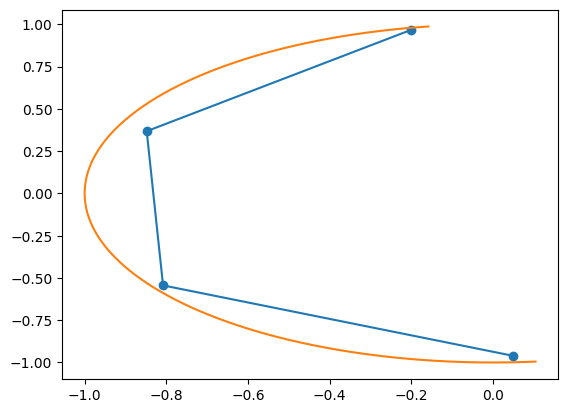

In [31]:

plt.plot([phase.real for phase in phase_estimates[:,1]], [phase.imag for phase in phase_estimates[:,1]])
plt.scatter([phase.real for phase in phase_estimates[:,1]], [phase.imag for phase in phase_estimates[:,1]])

ts = np.linspace(0.4, 0.46, 100)
ph = [np.exp(-1j * t * eigenvalues_sort[0]) for t in ts]
plt.plot([p.real for p in ph], [p.imag for p in ph])

#ts = np.linspace(0.22*0, 0.27*4, 100)
#ph1 = [np.exp(-1j * t * es) for t in ts]
#plt.plot([p.real for p in ph1], [p.imag for p in ph1])